## 1. Imports and Configuration

In [1]:
import sys
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# Add root directory to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from scripts.api.services.nasa_power.nasa_power_sync_adapter import NASAPowerSyncAdapter

# Configure logging
logger.remove()
logger.add(sys.stdout, level="INFO")

# Configure plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports completed")

Imports completed


## 2. Initialize NASA POWER Client

In [2]:
# Create synchronous adapter (no cache for demo)
nasa_adapter = NASAPowerSyncAdapter()

# Check API information
info = nasa_adapter.get_info()
print("\nNASA POWER API Information:")
for key, value in info.items():
    print(f"  {key}: {value}")

2025-12-04 02:12:15.004 | INFO     | scripts.api.services.nasa_power.nasa_power_sync_adapter:__init__:38 - NASAPowerSyncAdapter initialized

NASA POWER API Information:
  api: NASA POWER
  url: https://power.larc.nasa.gov/
  coverage: Global
  period: 1990-present (daily delay: 2-7 days)
  resolution: Daily (0.5° x 0.625° grid)
  range_limits: 7-30 days per request
  community: AG (Agronomy) - UPPERCASE required
  variables: 7
  license: Public Domain
  attribution: NASA Langley Research Center POWER Project funded through the NASA Earth Science Directorate Applied Science Program


## 3. Download Real Data - Piracicaba/SP (ESALQ/USP)

Let's download climate data for **Piracicaba/SP**, where ESALQ/USP is located.

**Coordinates**: -22.7089°S, -47.6361°W  
**Period**: Last 30 days

In [ ]:
# Define location: Piracicaba/SP (ESALQ/USP)
lat = -22.7089
lon = -47.6361
location_name = "Piracicaba/SP (ESALQ/USP)"

# Define period: last 30 days
end_date = datetime.now() - timedelta(days=7)  # 7 days ago (API delay)
start_date = end_date - timedelta(days=30)

print(f"Location: {location_name}")
print(f"Period: {start_date.date()} to {end_date.date()}")
print(f"Coordinates: {lat:.4f}°, {lon:.4f}°")

Location: Piracicaba/SP (ESALQ/USP)
Period: 2025-10-21 to 2025-11-20
Coordinates: -22.7089°, -47.6361°


In [4]:
%pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

# Download data
print("\nDownloading data from NASA POWER...\n")

nasa_data = nasa_adapter.get_daily_data_sync(
    lat=lat,
    lon=lon,
    start_date=start_date,
    end_date=end_date,
    community="AG"  # Agronomy community (UPPERCASE required)
)

print(f"\nData downloaded: {len(nasa_data)} records")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


2025-11-27 17:11:02.832 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:171 - Buscando NASA API: lat=-22.7089, lon=-47.6361
2025-11-27 17:11:02.833 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:201 - NASA POWER request: lat=-22.7089, lon=-47.6361, dates=20251021 to 20251120 (attempt 1)
2025-11-27 17:11:02.832 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:171 - Buscando NASA API: lat=-22.7089, lon=-47.6361
2025-11-27 17:11:02.833 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:201 - NASA POWER request: lat=-22.7089, lon=-47.6361, dates=20251021 to 20251120 (attempt 1)
2025-11-27 17:11:05.383 | INFO     | scripts.api.services.nasa_power.nasa_power_client:_parse_response:276 - NASA POWER: Parseados 31 registros
2025-11-27 17:11:05.383 | INFO     | scripts.api.services.nasa_power.nasa_power_sync_adapt

## 4. Convert to DataFrame and Explore

In [5]:
# Convert to DataFrame
df = pd.DataFrame([
    {
        'date': record.date,
        'temp_max': record.temp_max,
        'temp_min': record.temp_min,
        'temp_mean': record.temp_mean,
        'humidity': record.humidity,
        'wind_speed': record.wind_speed,
        'solar_radiation': record.solar_radiation,
        'precipitation': record.precipitation
    }
    for record in nasa_data
])

# Display first rows
print("\nFirst 5 rows of data:")
display(df.head())

# Descriptive statistics
print("\nDescriptive Statistics:")
display(df.describe())


First 5 rows of data:


,date,temp_max,temp_min,temp_mean,humidity,wind_speed,solar_radiation,precipitation
0,2025-10-21,27.97,9.40,18.06,52.61,3.29,28.17,0.0
1,2025-10-22,28.34,10.15,18.90,55.89,2.52,28.03,0.0
2,2025-10-23,29.50,11.00,19.98,54.11,2.08,27.96,0.0
3,2025-10-24,30.35,11.78,21.13,53.16,1.95,27.33,0.0
4,2025-10-25,33.02,14.27,24.01,48.10,2.33,23.57,0.0



Descriptive Statistics:


,temp_max,temp_min,temp_mean,humidity,wind_speed,solar_radiation,precipitation
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,31.148710,16.774194,23.640323,59.730000,2.453226,19.948387,2.437419
std,2.505156,3.327899,2.166486,9.303549,0.645525,8.280048,3.489316
min,25.870000,9.400000,18.060000,41.190000,1.210000,2.260000,0.000000
25%,29.285000,14.740000,22.925000,52.885000,2.005000,14.065000,0.000000
50%,31.150000,17.560000,23.600000,60.050000,2.340000,21.080000,0.590000
75%,33.020000,19.560000,25.195000,66.720000,2.930000,27.995000,3.660000
max,35.950000,21.090000,26.640000,78.630000,3.810000,30.350000,12.740000


## 5. Visualizations

### 5.1 Temperatures (Maximum, Minimum, Mean)

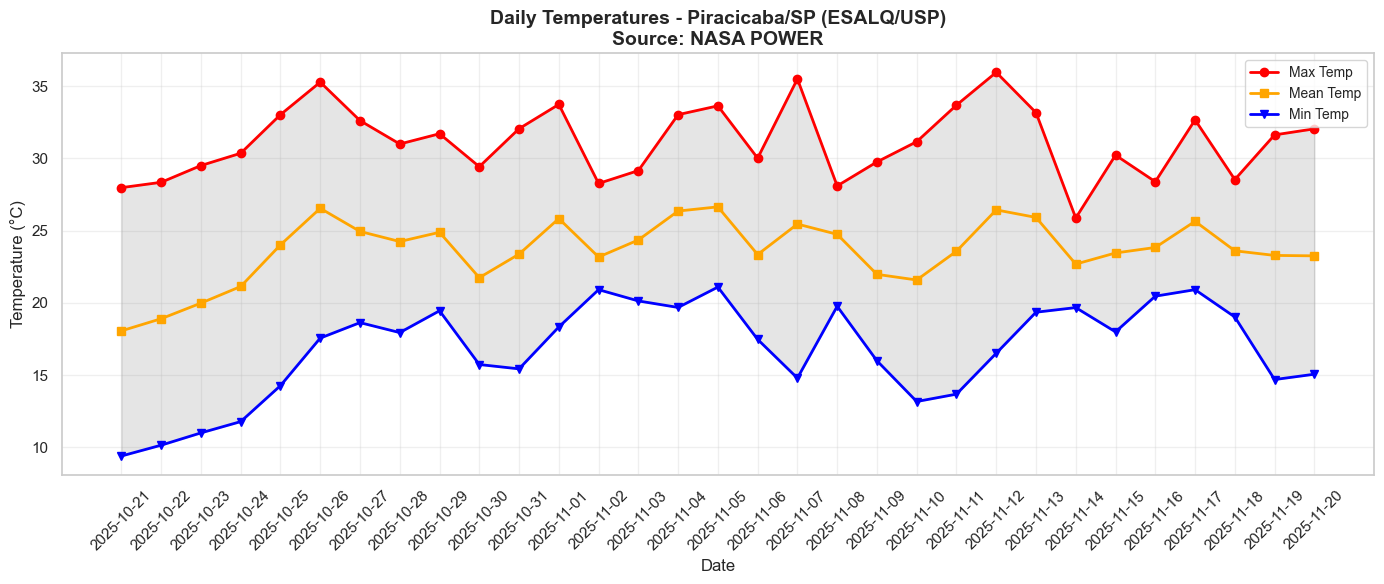

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df['date'], df['temp_max'], label='Max Temp', color='red', linewidth=2, marker='o')
ax.plot(df['date'], df['temp_mean'], label='Mean Temp', color='orange', linewidth=2, marker='s')
ax.plot(df['date'], df['temp_min'], label='Min Temp', color='blue', linewidth=2, marker='v')

ax.fill_between(df['date'], df['temp_min'], df['temp_max'], alpha=0.2, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title(f'Daily Temperatures - {location_name}\nSource: NASA POWER', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.2 Precipitation and Humidity

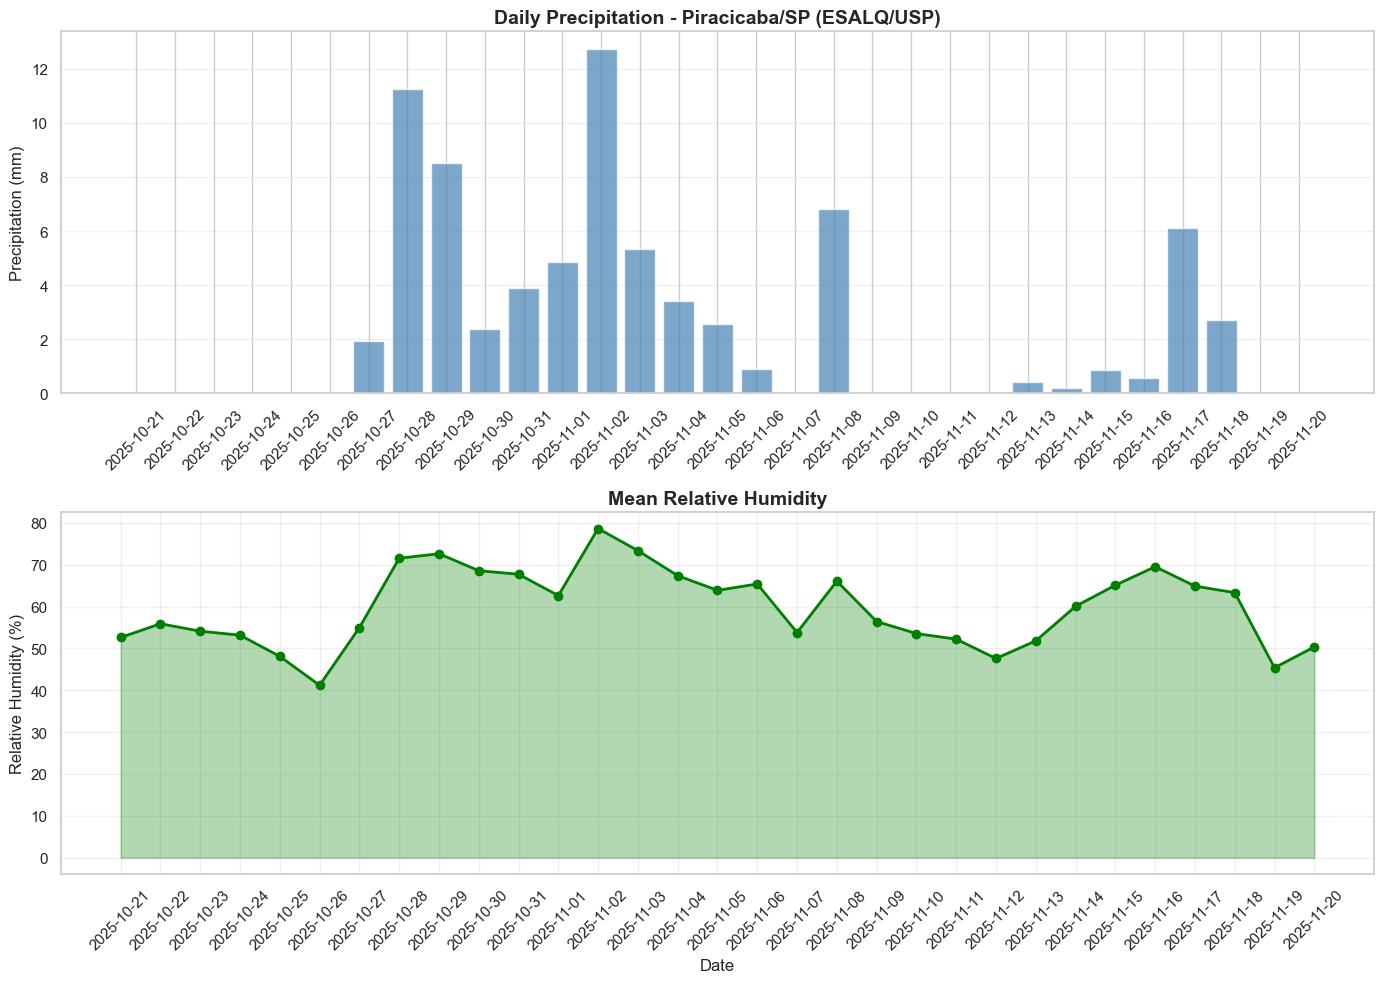

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Precipitation
ax1.bar(df['date'], df['precipitation'], color='steelblue', alpha=0.7)
ax1.set_ylabel('Precipitation (mm)', fontsize=12)
ax1.set_title(f'Daily Precipitation - {location_name}', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Relative Humidity
ax2.plot(df['date'], df['humidity'], color='green', linewidth=2, marker='o')
ax2.fill_between(df['date'], df['humidity'], alpha=0.3, color='green')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Relative Humidity (%)', fontsize=12)
ax2.set_title('Mean Relative Humidity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### 5.3 Solar Radiation and Wind Speed

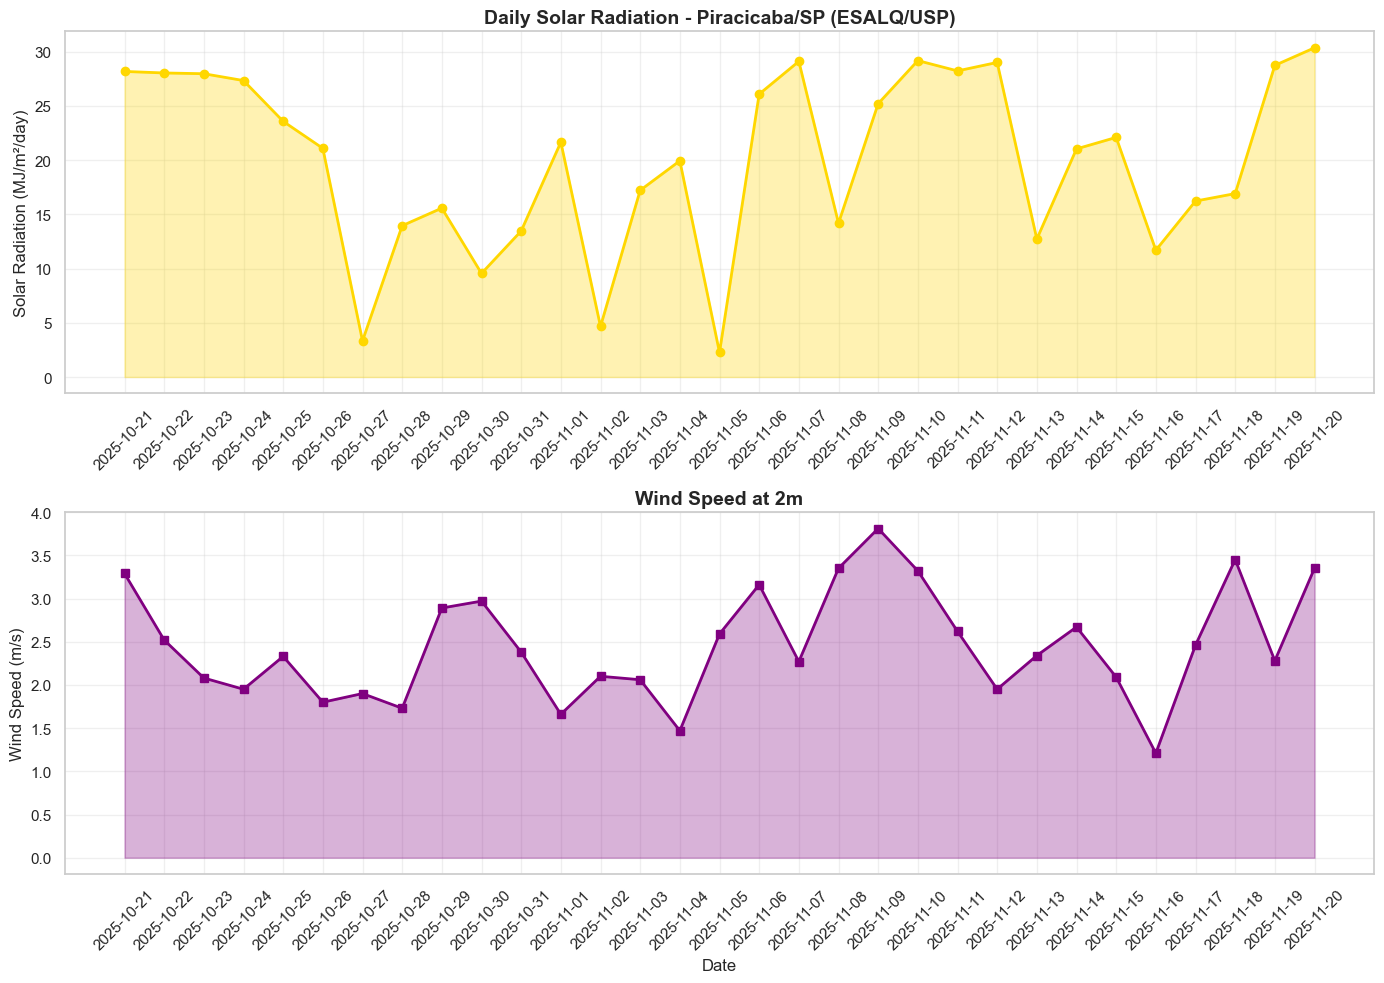

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Solar Radiation
ax1.plot(df['date'], df['solar_radiation'], color='gold', linewidth=2, marker='o')
ax1.fill_between(df['date'], df['solar_radiation'], alpha=0.3, color='gold')
ax1.set_ylabel('Solar Radiation (MJ/m²/day)', fontsize=12)
ax1.set_title(f'Daily Solar Radiation - {location_name}', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Wind Speed
ax2.plot(df['date'], df['wind_speed'], color='purple', linewidth=2, marker='s')
ax2.fill_between(df['date'], df['wind_speed'], alpha=0.3, color='purple')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Wind Speed (m/s)', fontsize=12)
ax2.set_title('Wind Speed at 2m', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## 6. Health Check

In [9]:
# Check API availability
is_healthy = nasa_adapter.health_check_sync()

if is_healthy:
    print("NASA POWER API is working correctly")
else:
    print("NASA POWER API is not accessible")

2025-11-27 17:11:06.860 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:171 - Buscando NASA API: lat=0.0, lon=0.0
2025-11-27 17:11:06.860 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:201 - NASA POWER request: lat=0.0, lon=0.0, dates=20251114 to 20251120 (attempt 1)
2025-11-27 17:11:06.860 | INFO     | scripts.api.services.nasa_power.nasa_power_client:get_daily_data:201 - NASA POWER request: lat=0.0, lon=0.0, dates=20251114 to 20251120 (attempt 1)
2025-11-27 17:11:08.812 | INFO     | scripts.api.services.nasa_power.nasa_power_client:_parse_response:276 - NASA POWER: Parseados 7 registros
NASA POWER API is working correctly
2025-11-27 17:11:08.812 | INFO     | scripts.api.services.nasa_power.nasa_power_client:_parse_response:276 - NASA POWER: Parseados 7 registros
NASA POWER API is working correctly


## 7. Save Data

In [10]:
# Save DataFrame as CSV
output_file = project_root / "data" / "csv" / "nasa_power_piracicaba_demo.csv"
output_file.parent.mkdir(parents=True, exist_ok=True)

df.to_csv(output_file, index=False)
print(f"\nData saved to: {output_file}")
print(f"Total records: {len(df)}")


Data saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\nasa_power_piracicaba_demo.csv
Total records: 31


---

## References

**NASA POWER**
- Website: https://power.larc.nasa.gov/
- Documentation: https://power.larc.nasa.gov/docs/
- Citation: NASA Langley Research Center POWER Project funded through the NASA Earth Science Directorate Applied Science Program

**License**: Public Domain (US Government)

---